In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks
from torchattacks import PGD, FGSM

from tqdm.notebook import tqdm

import clip

### Load CLIP Model

In [6]:
def load_CLIP_pretrained_model(model_name):
    model, preprocess_transform = clip.load(model_name)
    return model, preprocess_transform

### Load MNIST data

In [7]:
def load_MNIST_data(train_batch_size, test_batch_size, preprocess, kwargs):
    mnist_transform = transforms.Compose([transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor()])

    mnist_train_data = TVdatasets.MNIST(root='../data', 
                                        train=True,
                                        transform=preprocess,
                                        download=True)

    mnist_test_data = TVdatasets.MNIST(root='../data',
                                      train=False,
                                      transform=preprocess,
                                      download=True)

    print("Number of train samples:", len(mnist_train_data))
    print("Number of test samples:", len(mnist_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=mnist_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=mnist_test_data,
                                            batch_size=test_batch_size,
                                            shuffle=False,
                                            **kwargs)
    
    return trainloader, testloader

In [8]:
def model_overview_desc(model):
    input_resolution = model.visual.input_resolution
    context_length = model.context_length
    vocab_size = model.vocab_size
    
    num_parameters = 0
    for p in model.parameters():
        num_parameters += np.prod(p.shape)

    print("Image input resolution:", input_resolution)
    print("Text desc context length:", context_length)
    print("Vocab size:", vocab_size)
    print("Number of model parameters:", int(num_parameters))

### Show samples images

In [33]:
def show_sample_imgs(testloader, classnames):
    test_sample_imgs = []
    plt.figure(figsize=(16, 9))

    for _, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#         batch_imgs = batch_imgs.repeat(1, 3, 1, 1)

        for i in range(8):
            batch_imgs[i] = (batch_imgs[i] - batch_imgs[i].min()) / (batch_imgs[i].max() - batch_imgs[i].min())
            img = np.transpose(batch_imgs[i], (1,2,0))

#             print(img.shape, batch_imgs[i].shape[0])
#             print(img.min(), img.max())

            plt.subplot(2, 4, i+1)
            plt.imshow(img)
            plt.title("{}, {}".format(classnames[batch_labels[i]], list(img.shape)))
            plt.xticks([])
            plt.yticks([])
            
            test_sample_imgs.append(batch_imgs[i])

        break

    plt.tight_layout()
    plt.show()
    
    return test_sample_imgs

### Text descriptions based on classnames (prompt engineering)

In [34]:
def get_text_descriptions(classnames, text_templates):
    text_descriptions = []

    for class_name in classnames:
        for template in text_templates:
            text_descriptions.append(template.format(class_name))

    return text_descriptions

### Predict zero-shot classification for MNIST sample images using CLIP

In [35]:
def construct_similarity_map(model, batch_imgs, text_descriptions):
    batch_imgs = batch_imgs.to(device)
    text_tokens = clip.tokenize(text_descriptions).to(device)

#     print("Stacked images shape:", batch_imgs.shape)
#     print("Tokenized text shape:", text_tokens.shape)

    with torch.no_grad():
        img_features = model.encode_image(batch_imgs).float()
        text_features = model.encode_text(text_tokens).float()

#     print("Encoded images shape:", img_features.shape)
#     print("Encoded text shape:", text_features.shape)
    
    # each encoded image or text is a 512-dim feature vector in the embedding space
    # for each encoded image or text feature, divide by its length to make it a unit length vector
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)
    text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, text_features.T)
#     print("Cosine similarity map shape:", similarity_map.shape)
#     print(similarity_map.min(), similarity_map.max())
    
    return similarity_map

In [36]:
def plot_similarity_map(similarity_map, test_sample_imgs, text_descriptions):
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity_map, vmin=0.1, vmax=0.3)

    plt.yticks(range(10), text_descriptions, fontsize=18)
    plt.xticks([])

    for idx, img in enumerate(test_sample_imgs):
        img = np.transpose(img, (1,2,0))
        plt.imshow(img, extent=(idx - 0.5, idx + 0.5, -1.6, -0.6), origin="lower")

    num_imgs = similarity_map.shape[1]
    num_texts = similarity_map.shape[0]

    # plt.text(0, 1, f"saqib", ha="center", va="center", size=12)
    for x in range(num_imgs):
        for y in range(num_texts):
            plt.text(x, y, f"{similarity_map[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, num_texts - 0.5])
    plt.ylim([num_texts + 0.5, -2])

    plt.title("Cosine similarity between text and image features", size=20)

### Computing standard clean zero-shot accuracy of CLIP on MNIST test data

In [37]:
def compute_test_accuracy(model, testloader, text_descriptions):
    num_corr_pred = 0
    num_samples = 0
    model.eval()

    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#         batch_imgs = batch_imgs.repeat(1,3,1,1)
        batch_labels = batch_labels.to(device)

        similarity_map = construct_similarity_map(model, batch_imgs, text_descriptions)

        num_corr_pred += (torch.argmax(similarity_map, dim=1) == batch_labels).sum()
        num_samples += batch_imgs.shape[0]

    test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
    print("Standard clean zero-shot accuracy of CLIP on testset: {} %".format(test_accuracy))

## CLIP + MNIST

In [38]:
# define device type - cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device == torch.device("cuda") else {}

# print all available CLIP pretrained models and load one of the models
print("Available CLIP pretrained models:", clip.available_models())
model_CLIP, preprocess_CLIP = load_CLIP_pretrained_model("ViT-B/32")
print("\nImage Preprocessing Transform:\n", preprocess_CLIP)

# send model to device (cuda/cpu)
model_CLIP = model_CLIP.to(device)
model_CLIP.eval()

# describe model details
model_overview_desc(model_CLIP)

Available CLIP pretrained models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

Image Preprocessing Transform:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f9dda5e2ca0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Image input resolution: 224
Text desc context length: 77
Vocab size: 49408
Number of model parameters: 151277313


In [39]:
# load MNIST dataset
train_batch_size = 32
test_batch_size = 32
trainloader, testloader = load_MNIST_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

# get MNIST text descriptions (classnames + text templates)
# class_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
classnames = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
text_templates = ['a photo of digit {}']
text_descriptions = get_text_descriptions(classnames, text_templates)

Number of train samples: 60000
Number of test samples: 10000


  0%|          | 0/313 [00:00<?, ?it/s]

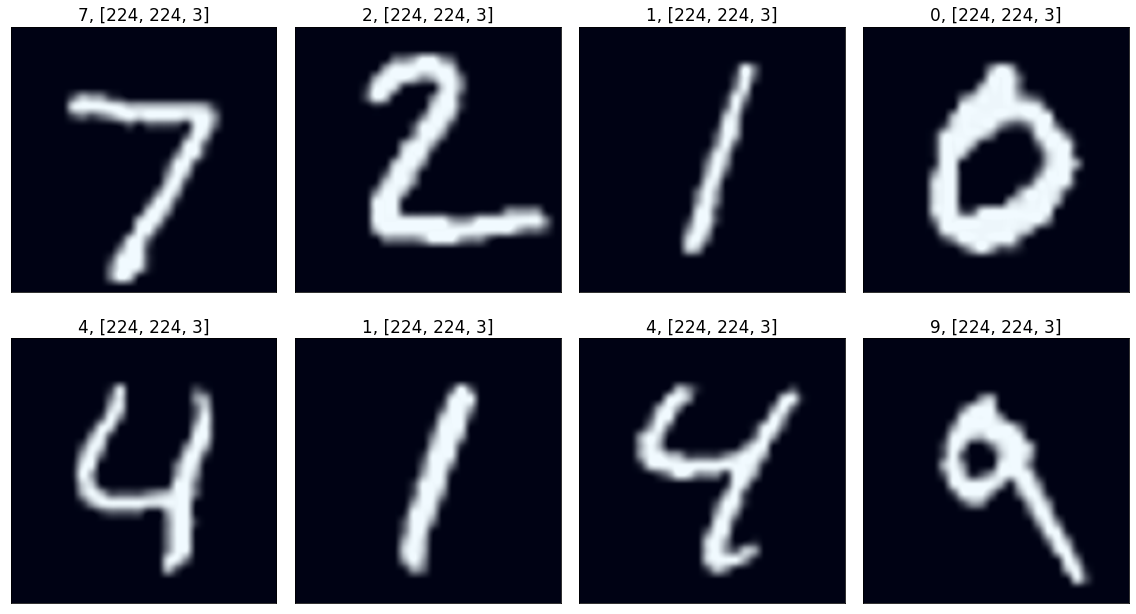

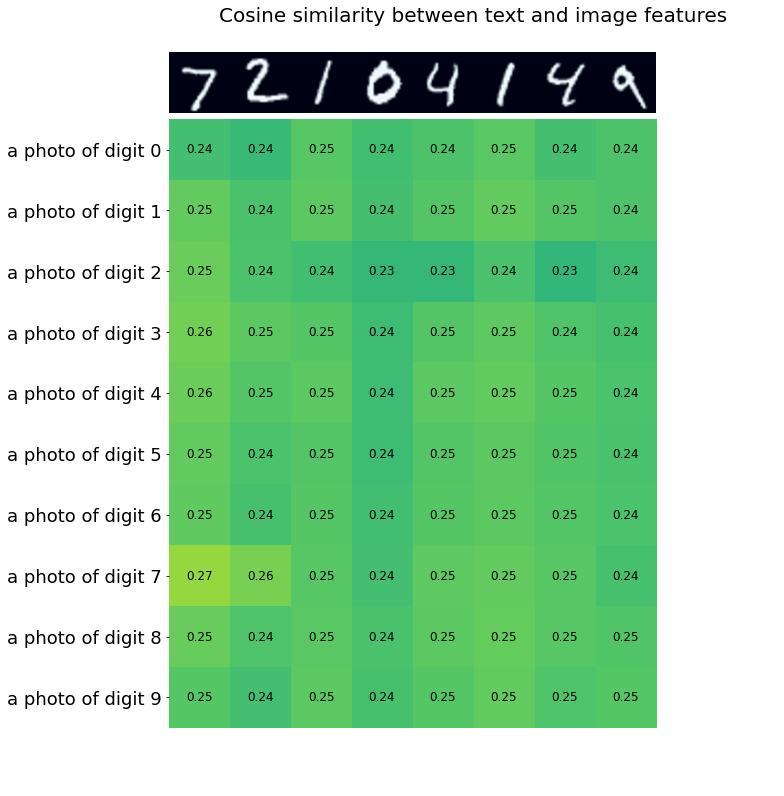

In [40]:
# show sample MNIST images
test_sample_imgs = show_sample_imgs(testloader, classnames)

# construct similarity map for test sample images and MNIST class descriptions
similarity_map = construct_similarity_map(model_CLIP, torch.tensor(np.stack(test_sample_imgs)), text_descriptions)
plot_similarity_map(similarity_map.cpu().numpy().T, test_sample_imgs, text_descriptions)

In [41]:
compute_test_accuracy(model_CLIP, testloader, text_descriptions)

Tokenized text shape: torch.Size([10, 77])
Encoded text shape: torch.Size([10, 512])


  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean zero-shot accuracy of CLIP on MNIST testset: 22.48 %


## CLIP + CIFAR10

In [42]:
def load_CIFAR10_data(train_batch_size, test_batch_size, preprocess, kwargs):
    cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

    cifar10_train_data = TVdatasets.CIFAR10(root="../data/", 
                                            train=True, 
                                            download=True, 
                                            transform=preprocess)

    cifar10_test_data = TVdatasets.CIFAR10(root="../data/", 
                                           train=False, 
                                           download=True, 
                                           transform=preprocess)

    print("Number of train samples:", len(cifar10_train_data))
    print("Number of test samples:", len(cifar10_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=cifar10_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=cifar10_test_data,
                                             batch_size=test_batch_size,
                                             shuffle=False,
                                            **kwargs)

    return trainloader, testloader

In [43]:
# load CIFAR10 dataset
train_batch_size = 32
test_batch_size = 32
trainloader, testloader = load_CIFAR10_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

# get CIFAR10 text descriptions (classnames + text templates)
classnames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
text_templates = ['a photo of a {}']
text_descriptions = get_text_descriptions(classnames, text_templates)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


  0%|          | 0/313 [00:00<?, ?it/s]

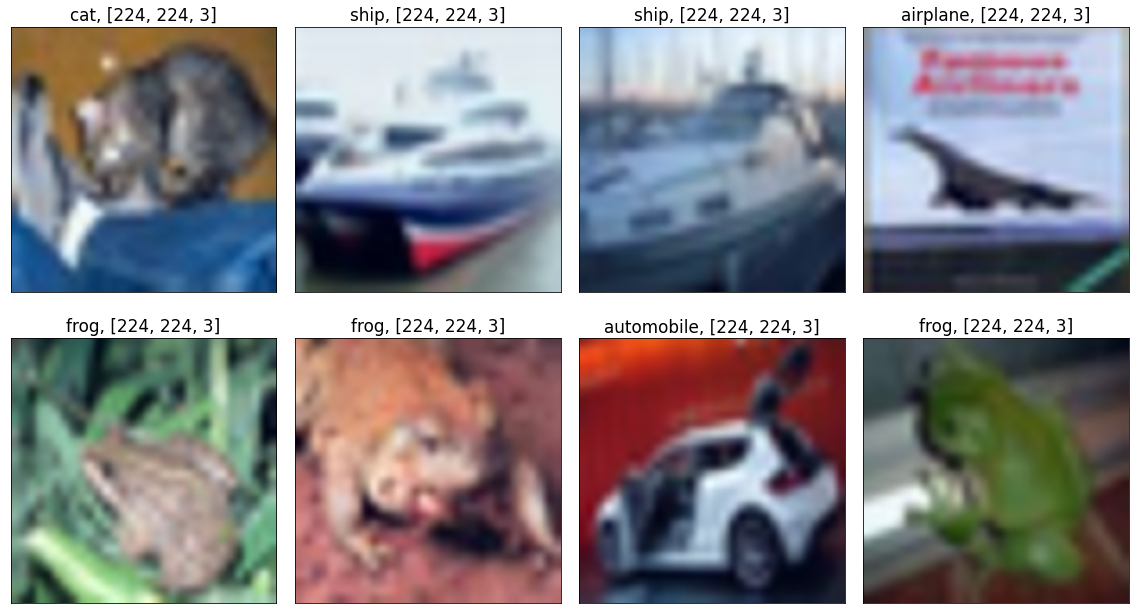

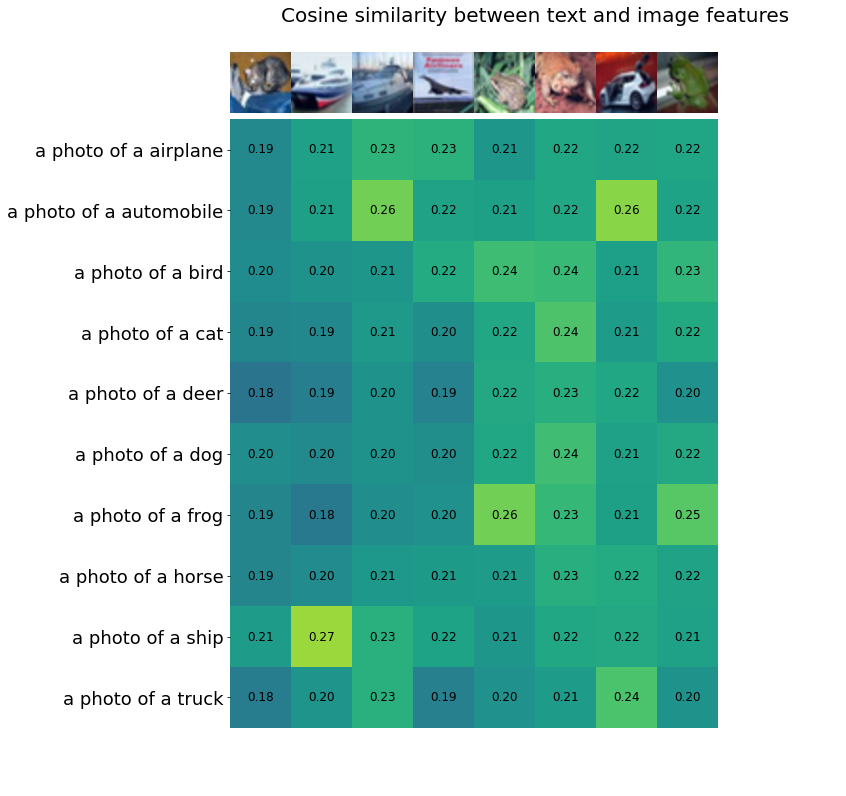

In [44]:
# show sample CIFAR10 images
test_sample_imgs = show_sample_imgs(testloader, classnames)

# construct similarity map for test sample images and MNIST class descriptions
similarity_map = construct_similarity_map(model_CLIP, torch.tensor(np.stack(test_sample_imgs)), text_descriptions)
plot_similarity_map(similarity_map.cpu().numpy().T, test_sample_imgs, text_descriptions)

In [45]:
compute_test_accuracy(model_CLIP, testloader, text_descriptions)

Tokenized text shape: torch.Size([10, 77])
Encoded text shape: torch.Size([10, 512])


  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean zero-shot accuracy of CLIP on MNIST testset: 88.78 %
